In [1]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:

import logging 
import pandas as pd
import matplotlib.pyplot as plt


logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(lineno)s:\n%(message)s',
    datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)
logger.info('Logger setup successfully')

21:54:19 - INFO - 11:
Logger setup successfully


# Data Exploration

In [3]:
data = pd.read_csv('adult.csv')
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


# Data Cleaning

21:54:19 - INFO - 3:
6 numeric columns found.
21:54:19 - INFO - 15:
Identified 216 outliers in age.
21:54:19 - INFO - 15:
Identified 1668 outliers in fnlwgt.
21:54:19 - INFO - 15:
Identified 3338 outliers in educational-num.
21:54:19 - INFO - 15:
Identified 7133 outliers in capital-gain.
21:54:19 - INFO - 15:
Identified 9306 outliers in capital-loss.
21:54:19 - INFO - 15:
Identified 20284 outliers in hours-per-week.


<AxesSubplot:>

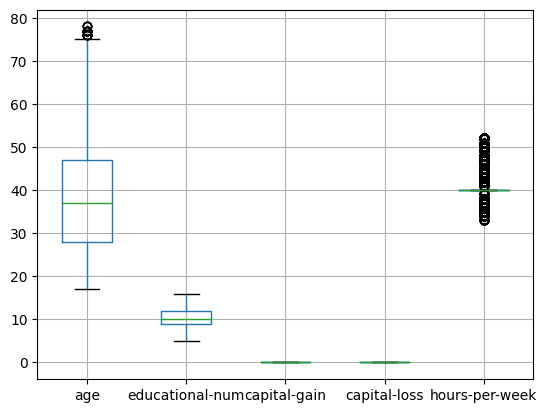

In [4]:
def remove_outliers(df):
    num_df = df.select_dtypes(include='number')
    logger.info(f'{len(num_df.columns)} numeric columns found.')
    initial_len = len(num_df)
    # loop through each column
    for col in num_df.columns:
        q1 = num_df[col].quantile(0.25)
        q3 = num_df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - iqr*1.5
        upper_bound = q3 + iqr*1.5
        
        # filter out outliers 
        df = df[(df[col]>=lower_bound)&(df[col]<=upper_bound)]
        logger.info(f'Identified {initial_len-len(df)} outliers in {col}.')
    return df

no_outlier_df = remove_outliers(data)

# 
no_outlier_df.select_dtypes(include='number')[['age','educational-num','capital-gain','capital-loss','hours-per-week']].boxplot()

In [5]:
# remove columns that add no value.
reduced_df = no_outlier_df.drop(['capital-gain','capital-loss','fnlwgt'],axis=1)
reduced_df['income'].value_counts()

<=50K    22539
>50K      6019
Name: income, dtype: int64

In [6]:
def consolidate_marital_status(status):
    if status in ['Never-married','Divorced','Separated','Widowed']:
        return 'Single'
    elif status in ['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse']:
        return 'Married'
    else:
        return status

reduced_df['marital-status'] = reduced_df['marital-status'].apply(consolidate_marital_status)
target_encoder = {'<=50K':0,'>50K':1}
reduced_df['income'] = reduced_df['income'].map(target_encoder)
reduced_df.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income
0,25,Private,11th,7,Single,Machine-op-inspct,Own-child,Black,Male,40,United-States,0
1,38,Private,HS-grad,9,Married,Farming-fishing,Husband,White,Male,50,United-States,0
2,28,Local-gov,Assoc-acdm,12,Married,Protective-serv,Husband,White,Male,40,United-States,1
6,29,?,HS-grad,9,Single,?,Unmarried,Black,Male,40,United-States,0
8,24,Private,Some-college,10,Single,Other-service,Unmarried,White,Female,40,United-States,0


In [7]:
non_num_df = reduced_df.select_dtypes(include='object')

for col in non_num_df.columns:
    if non_num_df[col].isin(['?']).any():
        logger.info(f'{col} contains missing values')
        logger.info(non_num_df[col].value_counts())
        


21:54:20 - INFO - 5:
workclass contains missing values
21:54:20 - INFO - 6:
Private             20729
Local-gov            2016
Self-emp-not-inc     1688
State-gov            1269
?                    1147
Federal-gov           982
Self-emp-inc          718
Without-pay             5
Never-worked            4
Name: workclass, dtype: int64
21:54:20 - INFO - 5:
occupation contains missing values
21:54:20 - INFO - 6:
Craft-repair         4214
Adm-clerical         3836
Exec-managerial      3546
Prof-specialty       3501
Sales                2866
Other-service        2406
Machine-op-inspct    2138
Transport-moving     1347
Handlers-cleaners    1258
?                    1151
Tech-support          955
Protective-serv       633
Farming-fishing       623
Priv-house-serv        73
Armed-Forces           11
Name: occupation, dtype: int64
21:54:20 - INFO - 5:
native-country contains missing values
21:54:20 - INFO - 6:
United-States                 25904
?                               495
Mexico   

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import numpy as np


reduced_df[col].replace('?',np.nan,inplace=True)
reduced_df[col].dropna(how='any',inplace=True)

cat_cols = reduced_df.select_dtypes(include='object').columns
le = LabelEncoder()

cat_df = reduced_df[cat_cols].apply(lambda col: le.fit_transform(col))
num_df = reduced_df.select_dtypes(include='number')

combined_df = pd.concat([cat_df,num_df],axis=1)

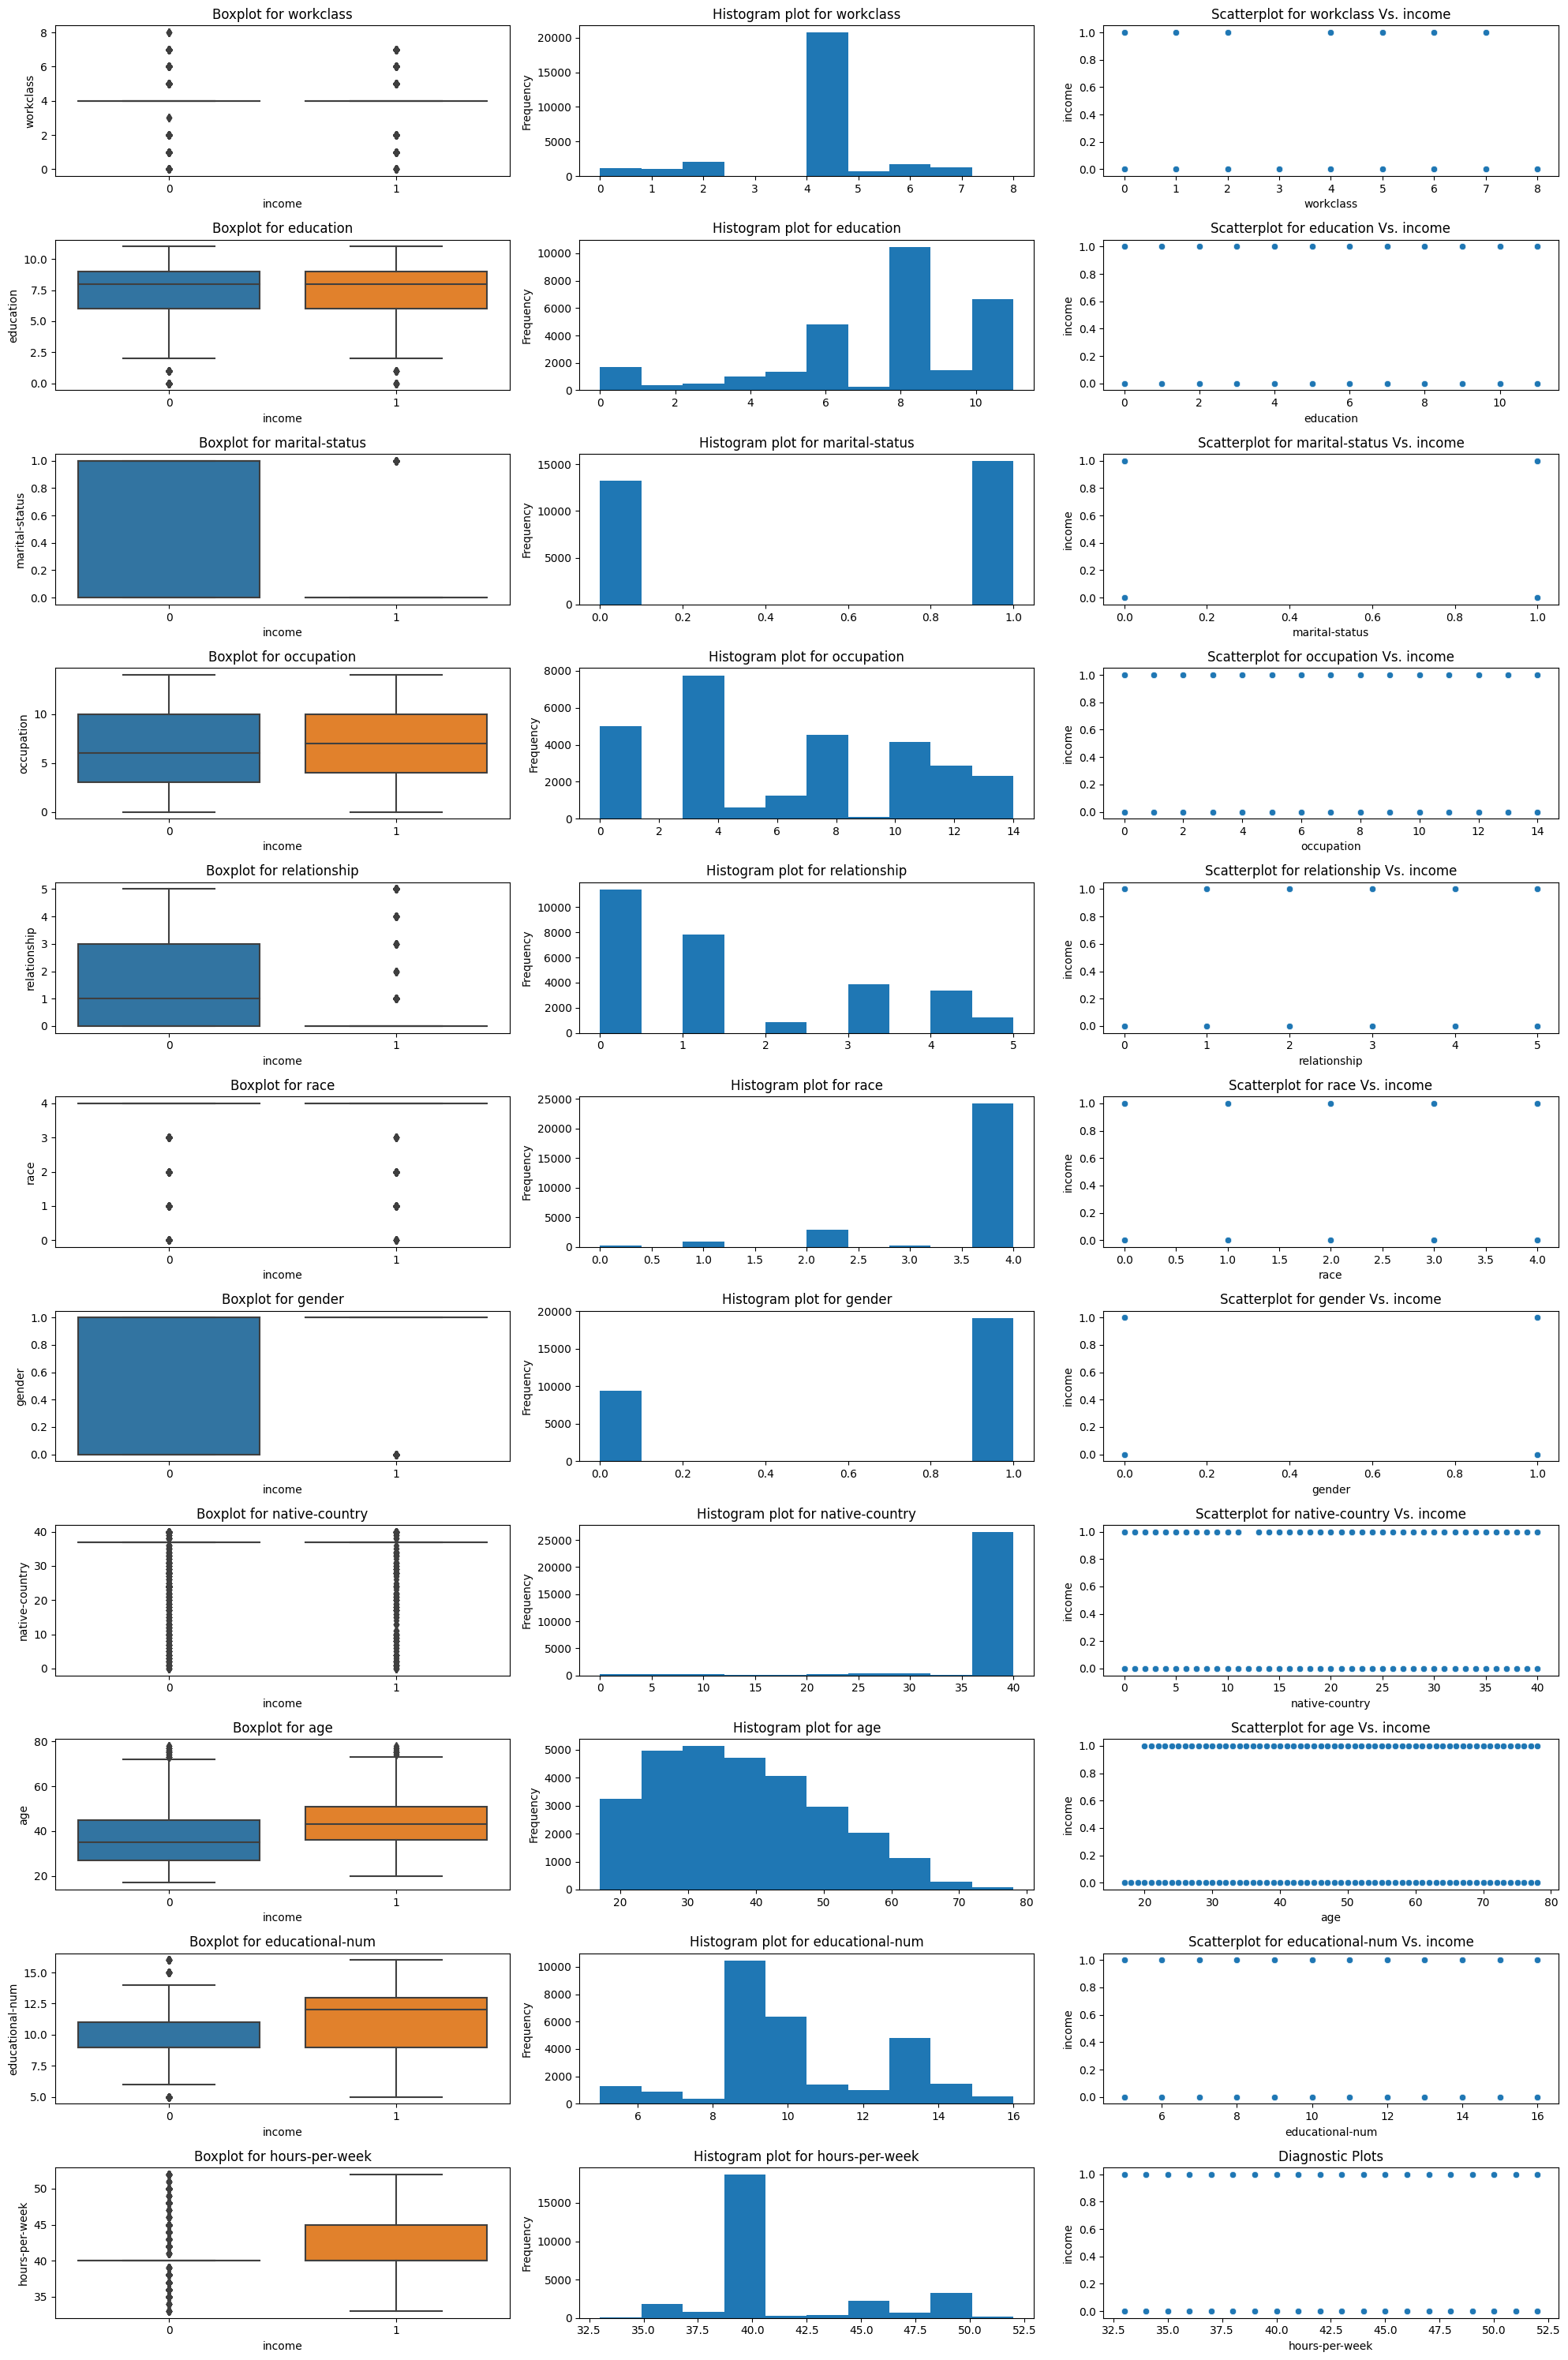

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_diagnostics(df, target):
    """
    Plots 3 diagnostics plots per column
    boxplot
    histogram
    
    """
    num_plots = len(df.columns) -1
    fig, axs = plt.subplots(num_plots,3, figsize=(20, 30))
    row = 0
    for col in df:
        if col == target:
            continue
            
        sns.boxplot(x=df[target], y=df[col], ax=axs[row,0])
        axs[row,0].set_title(f'Boxplot for {col}')

        df[col].plot(kind='hist',ax=axs[row,1])
        axs[row,1].set_title(f'Histogram plot for {col}')

        sns.scatterplot(y=df[target], x=df[col],ax=axs[row,2])
        axs[row,2].set_title(f'Scatterplot for {col} Vs. {target}')
    
        row += 1
    plt.title('Diagnostic Plots')
    plt.tight_layout()
    plt.show()
plot_diagnostics(combined_df, target='income')

# Assuming combined_df is your DataFrame and 'income' is the target column
# plot_diagnostics(combined_df.iloc[:340,:], target='income')



In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
# Split the data
logger.info(combined_df.columns)
X = combined_df.drop('income',axis=1)
y = combined_df['income'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)




23:41:29 - INFO - 6:
Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country', 'age',
       'educational-num', 'hours-per-week', 'income'],
      dtype='object')


# KNN Classification Model

In [27]:
accuracy_rate = []
for n in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy_rate.append(accuracy_score(y_test, y_pred))


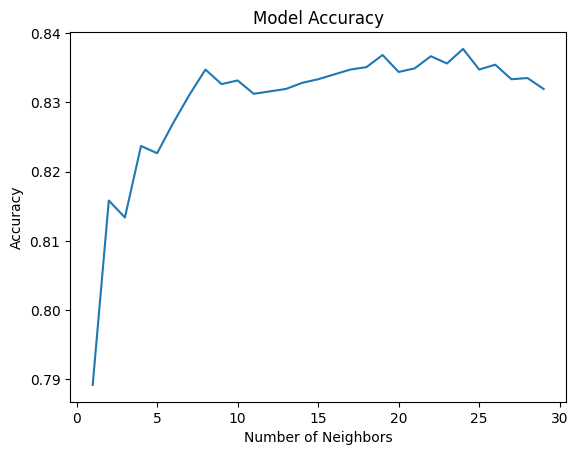

In [28]:
_, ax = plt.subplots()
ax.plot(range(1,30),accuracy_rate)
ax.set_title("Model Accuracy")
ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('Accuracy')

plt.show()

/Users/timothy/NEU Work/ALY6020/Coding Assignments/mod1/module1_assignment/.venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


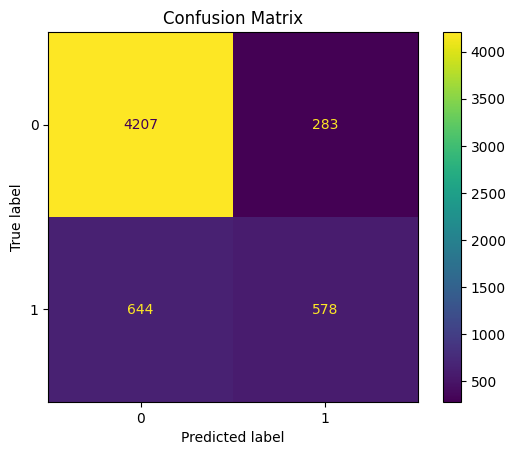

In [48]:
# KNeighbors Classifier
knc = KNeighborsClassifier(24)
knc.fit(X_train, y_train)

y_pred = knc.predict(X_test)

top_score = accuracy_score(y_test, y_pred)
top_score

plot_confusion_matrix(estimator=knc, X=X_test,y_true=y_test)
plt.title('Confusion Matrix')
plt.show()

In [47]:
confusion_matrix(y_test, y_pred)

array([[4207,  283],
       [ 644,  578]])

In [54]:
print(classification_report(y_test, y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      4490
           1       0.67      0.47      0.55      1222

    accuracy                           0.84      5712
   macro avg       0.77      0.70      0.73      5712
weighted avg       0.83      0.84      0.83      5712



In [55]:
combined_df['income'].value_counts()

0    22539
1     6019
Name: income, dtype: int64

# Feature Importance

In [ ]:
# Create table to track feature importance.


In [56]:
# Recreate train and test data but as dataframes instead of arrays
cond = np.random.rand(len(combined_df))>0.2
train_idx = np.where(cond)[0]
test_idx = np.where(~cond)[0]
train_df = combined_df.iloc[train_idx]
test_df = combined_df.iloc[test_idx]
X_train, y_train, X_test, y_test = train_df.drop('income',axis=1),train_df['income'],test_df.drop('income',axis=1),test_df['income']

X_tc = X_train.copy()

In [57]:
def feature_importance(X_train, y_train, X_test, y_test, top_score):
    data = {'workclass':[0],
        'education':[0],
        'marital-status':[0],
        'occupation':[0],
        'relationship':[0],
        'race':[0],
        'gender':[0],
        'native-country':[0],
        'age':[0],
        'educational-num':[0],
        'hours-per-week':[0]}
    feat_imp = pd.DataFrame(data)
    feat_imp
    for col in X_tc.columns:
        X_tc[col] = np.random.permutation(X_tc[col])
        knc.fit(X_train, y_train)
        feat_imp[col] = top_score - knc.score(X_tc, y_test)
    return feat_imp
        
X_tc = X_test.copy()   
feat_imp = feature_importance(X_train, y_train, X_tc, y_test, top_score)
feat_imp

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,age,educational-num,hours-per-week
0,0.022791,0.025442,0.026856,0.030215,0.037286,0.037109,0.038346,0.038877,0.055493,0.081832,0.083777


<Figure size 640x480 with 0 Axes>

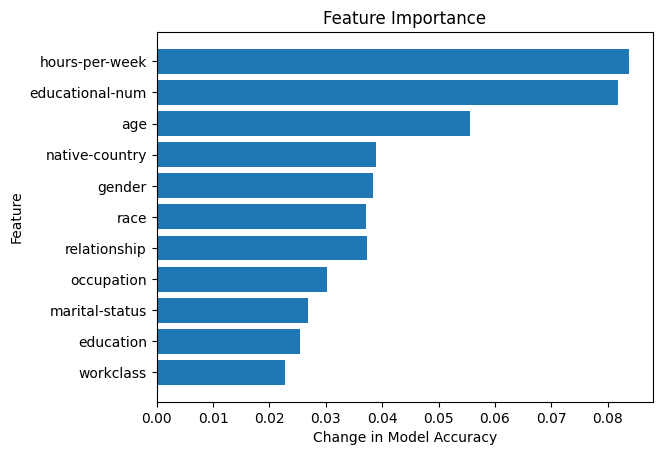

In [58]:
import matplotlib.pyplot as plt

# Assuming feat_imp is your DataFrame
plot_table = feat_imp.transpose()
plt.clf()
fig, ax = plt.subplots()
ax.barh(plot_table.index, plot_table.iloc[:, 0])  # plot_table.iloc[:, 0] selects the first (and only) column
ax.set_title('Feature Importance')
ax.set_xlabel('Change in Model Accuracy')
ax.set_ylabel('Feature')
plt.show()



In [ ]:
help(np.random.permutation)